# Feature Sieve for Regression
## Tabular Datasets

In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import openml as oml

from sklearn import datasets, linear_model, ensemble, tree, metrics
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from models.mlp import net, train_net, eval_net
from models.sifer_margin import SiFer_Margin, learn_main, learn_aux, forget_aux, train_margin, eval_fsmodel
from models.sifer_cross_entropy import SiFer_Cross, learn_main_ce, learn_aux_ce, forget_aux_ce, train_cross
from models.sifer_ordinal import SiFer_Ord, learn_main_ordinal, learn_aux_ordinal, forget_aux_ordinal, train_ordinal

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

torch.manual_seed(3407)
torch.cuda.set_device(2)
torch.cuda.manual_seed(3407)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Datasets

In [5]:
# fetching
dataset_name = "california"
df = datasets.fetch_openml(name =dataset_name, version = 2)

In [6]:
inputs = df['data']
targets = df['target']
print("Features: ", df['feature_names'])
print("Targets: ", df['target_names'])
print("Dataset size: ", inputs.shape)
inputs.head()

Features:  ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
Targets:  ['price']
Dataset size:  (20640, 8)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [7]:
targets.head()

0    1.709464
1    1.522790
2    1.508733
3    1.484555
4    1.486592
Name: price, dtype: float64

## Train, Validation and Test Split

In [8]:
TRAIN_PTS = int(inputs.shape[0] * 0.6)
VALID_PTS = int(inputs.shape[0] * 0.2)
TEST_PTS = int(inputs.shape[0] * 0.2)

train_inputs, train_targets = inputs[:TRAIN_PTS], targets[:TRAIN_PTS]
valid_inputs, valid_targets = inputs[TRAIN_PTS: TRAIN_PTS + VALID_PTS], targets[TRAIN_PTS: TRAIN_PTS + VALID_PTS]
test_inputs, test_targets = inputs[TRAIN_PTS + VALID_PTS: ], targets[TRAIN_PTS + VALID_PTS: ]

print(f"Train datapoints: {train_inputs.shape[0]}")
print(f"Validation datapoints: {valid_inputs.shape[0]}")
print(f"Test datapoints: {test_inputs.shape[0]}")

Train datapoints: 12384
Validation datapoints: 4128
Test datapoints: 4128


## Analysis of the dataset

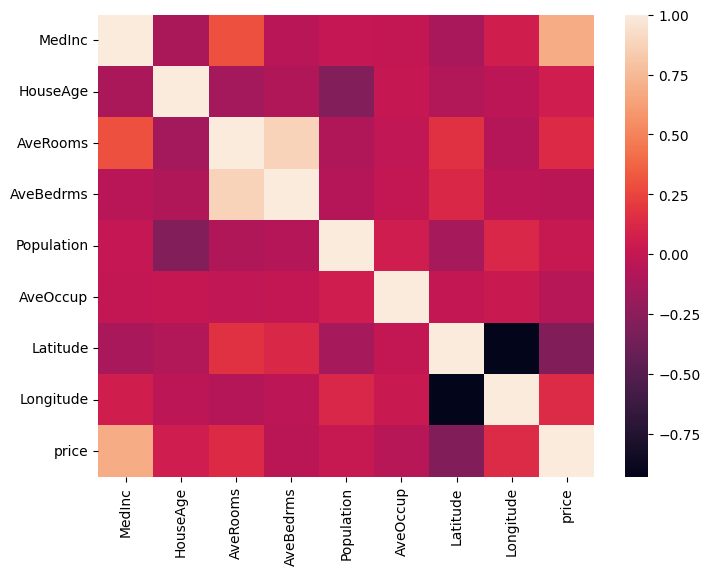

In [9]:
# correlation between the features and targets
plt.figure(figsize = (8, 6))
corr_df = pd.concat([train_inputs, train_targets], axis = 1)
corr_df = corr_df.corr()
sns.heatmap(corr_df)
plt.show()

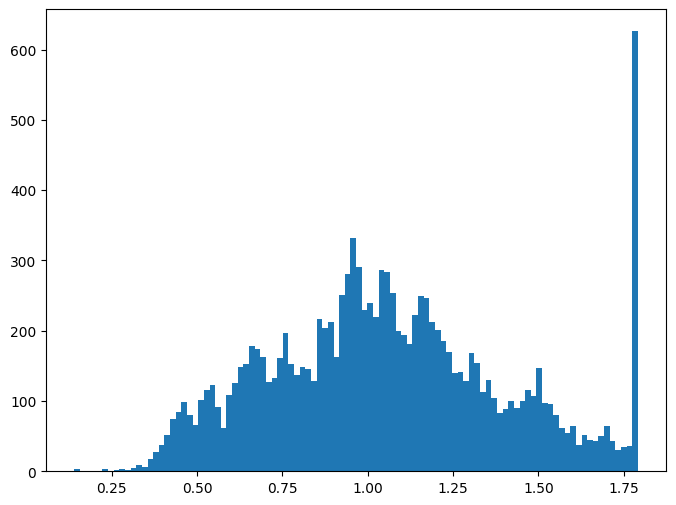

In [10]:
plt.figure(figsize = (8,6))
plt.hist(train_targets, bins = 100)
plt.show()

### Datasets and DataLoader

In [11]:
class CustomDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.targets[idx]
        return x,y

    def __len__(self):
        return self.data.shape[0]

EPSILON = 1e-12
# normalization of the input(min max normali)
norm_val_inputs = ((valid_inputs - valid_inputs.min()) / (valid_inputs.max() - valid_inputs.min()+EPSILON)).to_numpy()
norm_tst_inputs = ((test_inputs - test_inputs.min()) / (test_inputs.max() - test_inputs.min()+EPSILON)).to_numpy()
norm_train_inputs = ((train_inputs - train_inputs.min()) / (train_inputs.max() - train_inputs.min()+EPSILON)).to_numpy()

val_inputs, val_targets = valid_inputs.to_numpy(), valid_targets.to_numpy()
tst_inputs, tst_targets = test_inputs.to_numpy(), test_targets.to_numpy()
train_inputs, train_targets = train_inputs.to_numpy(), train_targets.to_numpy()

train_dataset = CustomDataset(train_inputs, train_targets)
train_dataloader = DataLoader(
    dataset = train_dataset, 
    shuffle = True, 
    batch_size = 64
)

norm_train_dataset = CustomDataset(norm_train_inputs, train_targets)
norm_train_dataloader = DataLoader(
    dataset = norm_train_dataset, 
    shuffle = True, 
    batch_size = 64
)

## 1) Random Forest Regressor

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [01:57<00:00, 10.64s/it]


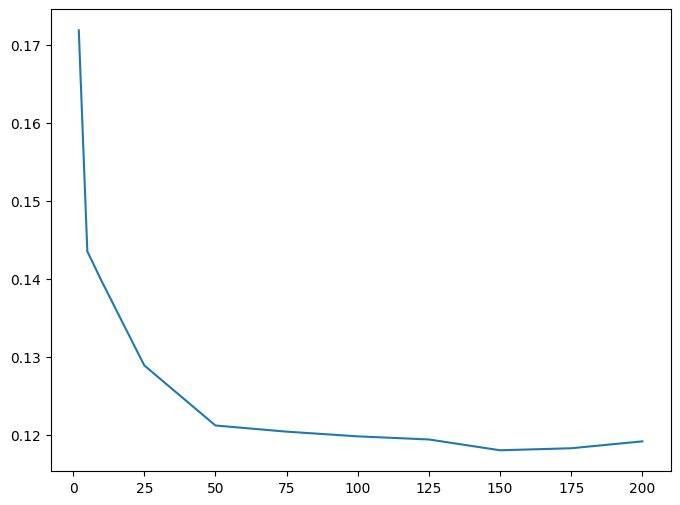

In [12]:
## hyperparameter tuning
num_estimators = [2, 5, 10, 25, 50, 75, 100, 125, 150, 175, 200]
val_losses = []

for num_est in tqdm(num_estimators):
    rf = ensemble.RandomForestRegressor(random_state = 42, n_estimators = num_est)
    rf.fit(norm_train_inputs, train_targets)
    val_preds = rf.predict(norm_val_inputs)

    val_loss = metrics.mean_squared_error(val_preds, val_targets)
    val_losses.append(val_loss)

best_n_estimator = num_estimators[val_losses.index(min(val_losses))]
plt.figure(figsize = (8,6))
plt.plot(num_estimators, val_losses)
plt.show()

In [13]:
rf = ensemble.RandomForestRegressor(random_state = 42, n_estimators = best_n_estimator)
rf.fit(norm_train_inputs, train_targets)
test_preds = rf.predict(norm_tst_inputs)

test_loss_rf = metrics.mean_squared_error(test_preds, tst_targets)
print(test_loss_rf)

0.08777712820836102


## 2) XGBoost regressor

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:01<00:00,  6.54it/s]


5


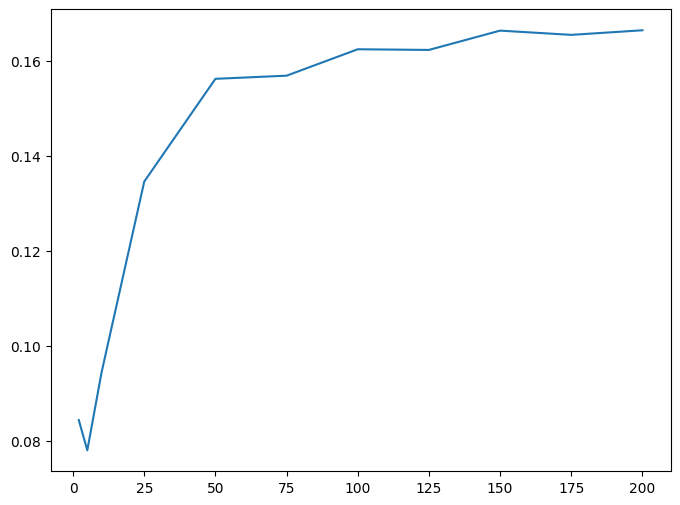

In [14]:
num_estimators = [2, 5, 10, 25, 50, 75, 100, 125, 150, 175, 200]
val_losses = []

for num_est in tqdm(num_estimators):
    xgb = XGBRegressor(random_state = 42, n_estimators = num_est)
    xgb.fit(norm_train_inputs, train_targets)
    val_preds = xgb.predict(norm_val_inputs)

    val_loss = metrics.mean_squared_error(val_preds, val_targets)
    val_losses.append(val_loss)

best_n_estimator = num_estimators[val_losses.index(min(val_losses))]
print(best_n_estimator)

plt.figure(figsize = (8,6))
plt.plot(num_estimators, val_losses)
plt.show()

In [15]:
xgb =XGBRegressor(random_state = 42, n_estimators = best_n_estimator)
xgb.fit(norm_train_inputs, train_targets)
test_preds = xgb.predict(norm_tst_inputs)

test_loss_xgb = metrics.mean_squared_error(test_preds, tst_targets)
print(test_loss_xgb)

0.07004330061040617


## 3) CatBoost

In [16]:
cat = CatBoostRegressor(random_seed = 42)
cat.fit(norm_train_inputs, train_targets)
test_preds = cat.predict(norm_tst_inputs)

test_loss_cat = metrics.mean_squared_error(test_preds, test_targets)
print(test_loss_cat)

Learning rate set to 0.060933
0:	learn: 0.3381949	total: 62.8ms	remaining: 1m 2s
1:	learn: 0.3262623	total: 69.7ms	remaining: 34.8s
2:	learn: 0.3146618	total: 77.2ms	remaining: 25.7s
3:	learn: 0.3041902	total: 92.2ms	remaining: 23s
4:	learn: 0.2939939	total: 95.4ms	remaining: 19s
5:	learn: 0.2846208	total: 98ms	remaining: 16.2s
6:	learn: 0.2758961	total: 101ms	remaining: 14.3s
7:	learn: 0.2679208	total: 103ms	remaining: 12.7s
8:	learn: 0.2605651	total: 105ms	remaining: 11.6s
9:	learn: 0.2536883	total: 107ms	remaining: 10.6s
10:	learn: 0.2473799	total: 110ms	remaining: 9.86s
11:	learn: 0.2414444	total: 113ms	remaining: 9.33s
12:	learn: 0.2357842	total: 116ms	remaining: 8.82s
13:	learn: 0.2306470	total: 118ms	remaining: 8.34s
14:	learn: 0.2259535	total: 121ms	remaining: 7.92s
15:	learn: 0.2216628	total: 123ms	remaining: 7.55s
16:	learn: 0.2173982	total: 125ms	remaining: 7.23s
17:	learn: 0.2135709	total: 127ms	remaining: 6.94s
18:	learn: 0.2099042	total: 129ms	remaining: 6.68s
19:	learn: 

## 4) LightGBM

 27%|█████████████████████████████████████▋                                                                                                    | 3/11 [00:00<00:00, 26.69it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1837
[LightGBM] [Info] Number of data points in the train set: 12384, number of used features: 8
[LightGBM] [Info] Start training from score 1.062439
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000452 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1837
[LightGBM] [Info] Number of data points in the train set: 12384, number of used features: 8
[LightGBM] [Info] Start training from score 1.062439
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000480 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1837
[LightGBM] [Info] Number of data points in the train set: 12384, number of used features: 8
[LightGBM] [Info] Start traini

 55%|███████████████████████████████████████████████████████████████████████████▎                                                              | 6/11 [00:00<00:00, 11.77it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000416 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1837
[LightGBM] [Info] Number of data points in the train set: 12384, number of used features: 8
[LightGBM] [Info] Start training from score 1.062439
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1837
[LightGBM] [Info] Number of data points in the train set: 12384, number of used features: 8
[LightGBM] [Info] Start training from score 1.062439
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000504 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1837
[LightGBM] [Info] Number of data points in the train set: 12384, number of used features: 8
[LightGBM] [Info] Start traini

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 8/11 [00:00<00:00,  7.90it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000428 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1837
[LightGBM] [Info] Number of data points in the train set: 12384, number of used features: 8
[LightGBM] [Info] Start training from score 1.062439
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000421 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1837
[LightGBM] [Info] Number of data points in the train set: 12384, number of used features: 8
[LightGBM] [Info] Start training from score 1.062439


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 10/11 [00:01<00:00,  5.46it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000580 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1837
[LightGBM] [Info] Number of data points in the train set: 12384, number of used features: 8
[LightGBM] [Info] Start training from score 1.062439


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:01<00:00,  6.12it/s]

25


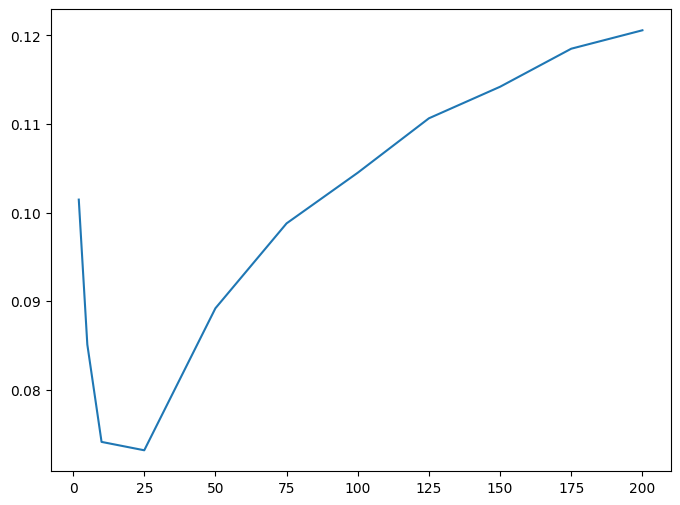

In [17]:
num_estimators = [2, 5, 10, 25, 50, 75, 100, 125, 150, 175, 200]
val_losses = []

for num_est in tqdm(num_estimators):
    lgbm = LGBMRegressor(random_state = 42, n_estimators = num_est)
    lgbm.fit(norm_train_inputs, train_targets)
    val_preds = lgbm.predict(norm_val_inputs)

    val_loss = metrics.mean_squared_error(val_preds, val_targets)
    val_losses.append(val_loss)

best_n_estimator = num_estimators[val_losses.index(min(val_losses))]
print(best_n_estimator)
plt.figure(figsize = (8,6))
plt.plot(num_estimators, val_losses)
plt.show()

In [18]:
lgbm = LGBMRegressor(random_state = 42, n_estimators = best_n_estimator)
lgbm.fit(norm_train_inputs, train_targets)
test_preds = lgbm.predict(norm_tst_inputs)

test_loss_lgbm = metrics.mean_squared_error(test_preds, tst_targets)
print(test_loss_lgbm)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000460 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1837
[LightGBM] [Info] Number of data points in the train set: 12384, number of used features: 8
[LightGBM] [Info] Start training from score 1.062439
0.06521395390477432


## 5) Linear Regression

In [19]:
lr = linear_model.LinearRegression()
lr.fit(norm_train_inputs, train_targets)
test_preds = lr.predict(norm_tst_inputs)

test_loss_lr = metrics.mean_squared_error(test_preds, tst_targets)
print(test_loss_lr)

0.07614427954882125


## 6) Tree Regressor

In [20]:
dtr = tree.DecisionTreeRegressor(random_state = 42)
dtr.fit(norm_train_inputs, train_targets)
tst_preds = dtr.predict(norm_tst_inputs)

test_loss_dtr = metrics.mean_squared_error(tst_preds, tst_targets)
print(test_loss_dtr)

0.1677761367702958


## 7) Gradient boosting Tree

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:34<00:00,  3.12s/it]

25


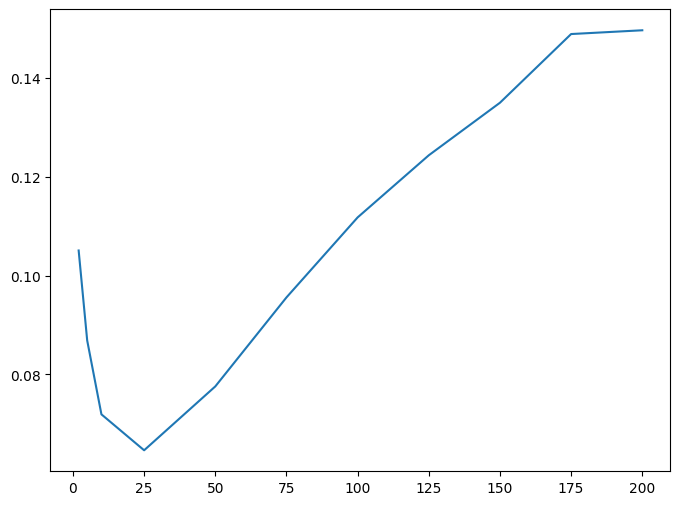

In [21]:
num_estimators = [2, 5, 10, 25, 50, 75, 100, 125, 150, 175, 200]
val_losses = []

for num_est in tqdm(num_estimators):
    gbt = ensemble.GradientBoostingRegressor(random_state = 42, n_estimators = num_est)
    gbt.fit(norm_train_inputs, train_targets)
    val_preds = gbt.predict(norm_val_inputs)

    val_loss = metrics.mean_squared_error(val_preds, val_targets)
    val_losses.append(val_loss)

best_n_estimator = num_estimators[val_losses.index(min(val_losses))]
print(best_n_estimator)

plt.figure(figsize = (8,6))
plt.plot(num_estimators, val_losses)
plt.show()

In [22]:
gbt = ensemble.GradientBoostingRegressor(random_state = 42, n_estimators = best_n_estimator)
gbt.fit(norm_train_inputs, train_targets)
test_preds = gbt.predict(norm_tst_inputs)

test_loss_gbt = metrics.mean_squared_error(test_preds, tst_targets)
print(test_loss_gbt)

0.05720323853297496


## 8) Vanilla Neural Network

In [23]:
lrs = [1e-3, 5e-3, 1e-4, 5e-4, 1e-5, 5e-5, 1e-2, 5e-2]
wds = [1e-5, 5e-4, 1e-4, 5e-3, 1e-3, 5e-2]

hyp_losses = np.zeros((len(lrs), len(wds)))

for i in range(len(lrs)):
    for j in range(len(wds)):
        model = net(val_inputs.shape[1], [32, 32, 32, 8], 1).to(device)
        model, train_losses, val_losses = train_net(model, norm_train_dataloader, val_inputs, val_targets, device, epochs = 5, lr = lrs[i], wd = wds[j])
        hyp_losses[i, j] += eval_net(model, norm_val_inputs, val_targets, device)
        print(f"Lr: {lrs[i]} Wds: {wds[j]}")
        print(f"Validation Loss: {hyp_losses[i,j]}")
        
best_lr, best_wd = np.unravel_index(np.argmin(hyp_losses), hyp_losses.shape)
print(f"Best LR: {lrs[best_lr]} Best WD: {wds[best_wd]}")

  0%|                                                                                                                                                   | 0/5 [00:00<?, ?it/s]/scratch/storage0/be20b032/miniconda3/lib/python3.11/site-packages/torch/utils/data/_utils/collate.py:222: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.08it/s]


Lr: 0.001 Wds: 1e-05
Validation Loss: 0.06745583564043045


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.12it/s]


Lr: 0.001 Wds: 0.0005
Validation Loss: 0.0738258957862854


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.12it/s]


Lr: 0.001 Wds: 0.0001
Validation Loss: 0.10967636108398438


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.12it/s]


Lr: 0.001 Wds: 0.005
Validation Loss: 0.07720072567462921


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.13it/s]


Lr: 0.001 Wds: 0.001
Validation Loss: 0.0741647258400917


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.11it/s]


Lr: 0.001 Wds: 0.05
Validation Loss: 0.11227049678564072


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.12it/s]


Lr: 0.005 Wds: 1e-05
Validation Loss: 0.1693468987941742


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.14it/s]


Lr: 0.005 Wds: 0.0005
Validation Loss: 0.10986537486314774


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.10it/s]


Lr: 0.005 Wds: 0.0001
Validation Loss: 0.0893714502453804


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.11it/s]


Lr: 0.005 Wds: 0.005
Validation Loss: 0.08989613503217697


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.15it/s]


Lr: 0.005 Wds: 0.001
Validation Loss: 0.0943656712770462


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.14it/s]


Lr: 0.005 Wds: 0.05
Validation Loss: 0.118289053440094


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.12it/s]


Lr: 0.0001 Wds: 1e-05
Validation Loss: 0.1157071515917778


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.11it/s]


Lr: 0.0001 Wds: 0.0005
Validation Loss: 0.12048596143722534


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.09it/s]


Lr: 0.0001 Wds: 0.0001
Validation Loss: 0.123705193400383


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.12it/s]


Lr: 0.0001 Wds: 0.005
Validation Loss: 0.10934285819530487


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.10it/s]


Lr: 0.0001 Wds: 0.001
Validation Loss: 0.11632122099399567


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.11it/s]


Lr: 0.0001 Wds: 0.05
Validation Loss: 0.9430018067359924


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.11it/s]


Lr: 0.0005 Wds: 1e-05
Validation Loss: 0.06811020523309708


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.13it/s]


Lr: 0.0005 Wds: 0.0005
Validation Loss: 0.07549962401390076


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.12it/s]


Lr: 0.0005 Wds: 0.0001
Validation Loss: 0.07706318795681


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.19it/s]


Lr: 0.0005 Wds: 0.005
Validation Loss: 0.08103660494089127


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.24it/s]


Lr: 0.0005 Wds: 0.001
Validation Loss: 0.08198494464159012


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.21it/s]


Lr: 0.0005 Wds: 0.05
Validation Loss: 0.10861330479383469


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.21it/s]


Lr: 1e-05 Wds: 1e-05
Validation Loss: 1.6882281303405762


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.13it/s]


Lr: 1e-05 Wds: 0.0005
Validation Loss: 0.6920297145843506


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.12it/s]


Lr: 1e-05 Wds: 0.0001
Validation Loss: 0.6515264511108398


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.11it/s]


Lr: 1e-05 Wds: 0.005
Validation Loss: 1.1311556100845337


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.14it/s]


Lr: 1e-05 Wds: 0.001
Validation Loss: 1.149779200553894


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.12it/s]


Lr: 1e-05 Wds: 0.05
Validation Loss: 0.7483593821525574


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.14it/s]


Lr: 5e-05 Wds: 1e-05
Validation Loss: 0.260634183883667


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.13it/s]


Lr: 5e-05 Wds: 0.0005
Validation Loss: 0.23279127478599548


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.14it/s]


Lr: 5e-05 Wds: 0.0001
Validation Loss: 0.12064840644598007


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.13it/s]


Lr: 5e-05 Wds: 0.005
Validation Loss: 0.1372983455657959


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.12it/s]


Lr: 5e-05 Wds: 0.001
Validation Loss: 0.25450143218040466


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.13it/s]


Lr: 5e-05 Wds: 0.05
Validation Loss: 0.17455631494522095


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.14it/s]


Lr: 0.01 Wds: 1e-05
Validation Loss: 0.14342258870601654


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.12it/s]


Lr: 0.01 Wds: 0.0005
Validation Loss: 0.09747374802827835


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.13it/s]


Lr: 0.01 Wds: 0.0001
Validation Loss: 0.11278532445430756


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.12it/s]


Lr: 0.01 Wds: 0.005
Validation Loss: 0.09147527813911438


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.13it/s]


Lr: 0.01 Wds: 0.001
Validation Loss: 0.09357143193483353


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.16it/s]


Lr: 0.01 Wds: 0.05
Validation Loss: 0.11941301822662354


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.12it/s]


Lr: 0.05 Wds: 1e-05
Validation Loss: 0.14070969820022583


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.13it/s]


Lr: 0.05 Wds: 0.0005
Validation Loss: 0.09066931158304214


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.14it/s]


Lr: 0.05 Wds: 0.0001
Validation Loss: 0.10823001712560654


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.11it/s]


Lr: 0.05 Wds: 0.005
Validation Loss: 0.0881926640868187


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.11it/s]


Lr: 0.05 Wds: 0.001
Validation Loss: 0.0843072459101677


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.11it/s]

Lr: 0.05 Wds: 0.05
Validation Loss: 0.11807060986757278
Best LR: 0.001 Best WD: 1e-05


In [24]:
model = net(val_inputs.shape[1], [32, 32, 32, 8], 1).to(device)
model, train_losses, val_losses = train_net(model, norm_train_dataloader, val_inputs, val_targets, device, lr = lrs[best_lr], wd = wds[best_wd])
test_loss_mlp = eval_net(model, norm_tst_inputs, tst_targets, device)
print(test_loss_mlp)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.12it/s]

tensor(0.0594)


## 9) SiFer Margin Forgetting Model

In [25]:
if dataset_name in ["california", 'wine_quality']:
    margins = [5e-3, 1e-3, 5e-2, 1e-2, 1e-1, 5e-1, 1, 2, 5]
elif dataset_name in ['cpu_act', 'fifa',  'superconduct', 'elevators', 'pol']:
    margins = [1, 2, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200]
    
forget_lrs = [5e-4, 1e-4, 5e-3, 1e-3, 5e-2, 1e-2]
forget_iters = [2, 5]

hyp_losses = np.zeros((len(margins), len(forget_lrs), len(forget_iters)))
for i in range(len(margins)):
    for j in range(len(forget_lrs)):
        for k in range(len(forget_iters)):
            margin = SiFer_Margin([32, 32, 32, 8], [8, 8], 1, val_inputs.shape[1], 1).to(device)
            margin, train_losses, val_losses = train_margin(margin, norm_train_dataloader, val_inputs, val_targets, device, margin = margins[i], forget_iters = forget_iters[k], lrs = [lrs[best_lr], lrs[best_lr], forget_lrs[j]], epochs = 5)
            hyp_losses[i, j, k] += eval_fsmodel(margin, norm_val_inputs, val_targets, device)
            print(f"[{i*(len(forget_lrs) * len(forget_iters)) + j*(len(forget_iters)) + k + 1} / {len(margins) * len(forget_lrs)* len(forget_iters)}] Margin: {margins[i]} Forget Lr: {forget_lrs[j]} Forget Iter: {forget_iters[k]}")
            print(hyp_losses[i,j,k])
            
best_margin, best_forget_lr, best_forget_iter = np.unravel_index(np.argmin(hyp_losses), hyp_losses.shape)
print(f"Best Margin: {margins[best_margin]} Best Forget LR: {forget_lrs[best_forget_lr]} Best Forget Iters: {forget_iters[best_forget_iter]}")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.66s/it]


[1 / 108] Margin: 0.005 Forget Lr: 0.0005 Forget Iter: 2
0.08746475726366043


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.26s/it]


[2 / 108] Margin: 0.005 Forget Lr: 0.0005 Forget Iter: 5
0.07088044285774231


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.49s/it]


[3 / 108] Margin: 0.005 Forget Lr: 0.0001 Forget Iter: 2
0.07972752302885056


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.26s/it]


[4 / 108] Margin: 0.005 Forget Lr: 0.0001 Forget Iter: 5
0.08810888975858688


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.52s/it]


[5 / 108] Margin: 0.005 Forget Lr: 0.005 Forget Iter: 2
0.09675692766904831


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.24s/it]


[6 / 108] Margin: 0.005 Forget Lr: 0.005 Forget Iter: 5
0.07594278454780579


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.54s/it]


[7 / 108] Margin: 0.005 Forget Lr: 0.001 Forget Iter: 2
0.0751921758055687


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.24s/it]


[8 / 108] Margin: 0.005 Forget Lr: 0.001 Forget Iter: 5
0.14026154577732086


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.52s/it]


[9 / 108] Margin: 0.005 Forget Lr: 0.05 Forget Iter: 2
0.11163625866174698


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.21s/it]


[10 / 108] Margin: 0.005 Forget Lr: 0.05 Forget Iter: 5
0.07546985149383545


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.47s/it]


[11 / 108] Margin: 0.005 Forget Lr: 0.01 Forget Iter: 2
0.07279154658317566


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.24s/it]


[12 / 108] Margin: 0.005 Forget Lr: 0.01 Forget Iter: 5
0.07569645345211029


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.49s/it]


[13 / 108] Margin: 0.001 Forget Lr: 0.0005 Forget Iter: 2
0.07390769571065903


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.25s/it]


[14 / 108] Margin: 0.001 Forget Lr: 0.0005 Forget Iter: 5
0.08120942115783691


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.32s/it]


[15 / 108] Margin: 0.001 Forget Lr: 0.0001 Forget Iter: 2
0.08226755261421204


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.18s/it]


[16 / 108] Margin: 0.001 Forget Lr: 0.0001 Forget Iter: 5
0.08018630743026733


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.53s/it]


[17 / 108] Margin: 0.001 Forget Lr: 0.005 Forget Iter: 2
0.11470821499824524


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.25s/it]


[18 / 108] Margin: 0.001 Forget Lr: 0.005 Forget Iter: 5
0.07921654731035233


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.53s/it]


[19 / 108] Margin: 0.001 Forget Lr: 0.001 Forget Iter: 2
0.09309030324220657


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.21s/it]


[20 / 108] Margin: 0.001 Forget Lr: 0.001 Forget Iter: 5
0.07943937182426453


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.54s/it]


[21 / 108] Margin: 0.001 Forget Lr: 0.05 Forget Iter: 2
0.10233398526906967


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.25s/it]


[22 / 108] Margin: 0.001 Forget Lr: 0.05 Forget Iter: 5
0.07929756492376328


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.50s/it]


[23 / 108] Margin: 0.001 Forget Lr: 0.01 Forget Iter: 2
0.06740880757570267


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.24s/it]


[24 / 108] Margin: 0.001 Forget Lr: 0.01 Forget Iter: 5
0.0658932775259018


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.54s/it]


[25 / 108] Margin: 0.05 Forget Lr: 0.0005 Forget Iter: 2
0.0752296894788742


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.27s/it]


[26 / 108] Margin: 0.05 Forget Lr: 0.0005 Forget Iter: 5
0.07942397892475128


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.51s/it]


[27 / 108] Margin: 0.05 Forget Lr: 0.0001 Forget Iter: 2
0.08097773790359497


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.24s/it]


[28 / 108] Margin: 0.05 Forget Lr: 0.0001 Forget Iter: 5
0.07909563183784485


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.53s/it]


[29 / 108] Margin: 0.05 Forget Lr: 0.005 Forget Iter: 2
0.10589582473039627


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.22s/it]


[30 / 108] Margin: 0.05 Forget Lr: 0.005 Forget Iter: 5
0.08519687503576279


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.50s/it]


[31 / 108] Margin: 0.05 Forget Lr: 0.001 Forget Iter: 2
0.08135242760181427


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.24s/it]


[32 / 108] Margin: 0.05 Forget Lr: 0.001 Forget Iter: 5
0.08305639773607254


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.60s/it]


[33 / 108] Margin: 0.05 Forget Lr: 0.05 Forget Iter: 2
0.14759279787540436


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.25s/it]


[34 / 108] Margin: 0.05 Forget Lr: 0.05 Forget Iter: 5
0.07723201811313629


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.50s/it]


[35 / 108] Margin: 0.05 Forget Lr: 0.01 Forget Iter: 2
0.0731460228562355


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.25s/it]


[36 / 108] Margin: 0.05 Forget Lr: 0.01 Forget Iter: 5
0.08559374511241913


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.48s/it]


[37 / 108] Margin: 0.01 Forget Lr: 0.0005 Forget Iter: 2
0.0733218863606453


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.25s/it]


[38 / 108] Margin: 0.01 Forget Lr: 0.0005 Forget Iter: 5
0.0781152993440628


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.46s/it]


[39 / 108] Margin: 0.01 Forget Lr: 0.0001 Forget Iter: 2
0.07445327937602997


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.13s/it]


[40 / 108] Margin: 0.01 Forget Lr: 0.0001 Forget Iter: 5
0.070119209587574


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.52s/it]


[41 / 108] Margin: 0.01 Forget Lr: 0.005 Forget Iter: 2
0.07099969685077667


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.28s/it]


[42 / 108] Margin: 0.01 Forget Lr: 0.005 Forget Iter: 5
0.07743121683597565


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.50s/it]


[43 / 108] Margin: 0.01 Forget Lr: 0.001 Forget Iter: 2
0.08860952407121658


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.25s/it]


[44 / 108] Margin: 0.01 Forget Lr: 0.001 Forget Iter: 5
0.061609238386154175


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.55s/it]


[45 / 108] Margin: 0.01 Forget Lr: 0.05 Forget Iter: 2
0.07579444348812103


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.30s/it]


[46 / 108] Margin: 0.01 Forget Lr: 0.05 Forget Iter: 5
0.07283416390419006


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.55s/it]


[47 / 108] Margin: 0.01 Forget Lr: 0.01 Forget Iter: 2
0.07206473499536514


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.25s/it]


[48 / 108] Margin: 0.01 Forget Lr: 0.01 Forget Iter: 5
0.0829831212759018


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.49s/it]


[49 / 108] Margin: 0.1 Forget Lr: 0.0005 Forget Iter: 2
0.08121741563081741


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.29s/it]


[50 / 108] Margin: 0.1 Forget Lr: 0.0005 Forget Iter: 5
0.06963612139225006


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.53s/it]


[51 / 108] Margin: 0.1 Forget Lr: 0.0001 Forget Iter: 2
0.07258113473653793


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.26s/it]


[52 / 108] Margin: 0.1 Forget Lr: 0.0001 Forget Iter: 5
0.07249528169631958


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.54s/it]


[53 / 108] Margin: 0.1 Forget Lr: 0.005 Forget Iter: 2
0.07007786631584167


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.25s/it]


[54 / 108] Margin: 0.1 Forget Lr: 0.005 Forget Iter: 5
0.07830745726823807


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.55s/it]


[55 / 108] Margin: 0.1 Forget Lr: 0.001 Forget Iter: 2
0.06810025870800018


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.27s/it]


[56 / 108] Margin: 0.1 Forget Lr: 0.001 Forget Iter: 5
0.07521240413188934


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.53s/it]


[57 / 108] Margin: 0.1 Forget Lr: 0.05 Forget Iter: 2
0.10126400738954544


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.27s/it]


[58 / 108] Margin: 0.1 Forget Lr: 0.05 Forget Iter: 5
0.0753379687666893


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.51s/it]


[59 / 108] Margin: 0.1 Forget Lr: 0.01 Forget Iter: 2
0.08450530469417572


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.24s/it]


[60 / 108] Margin: 0.1 Forget Lr: 0.01 Forget Iter: 5
0.10447844117879868


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.52s/it]


[61 / 108] Margin: 0.5 Forget Lr: 0.0005 Forget Iter: 2
0.11221802234649658


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.27s/it]


[62 / 108] Margin: 0.5 Forget Lr: 0.0005 Forget Iter: 5
0.06925477832555771


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.54s/it]


[63 / 108] Margin: 0.5 Forget Lr: 0.0001 Forget Iter: 2
0.07841867208480835


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.12s/it]


[64 / 108] Margin: 0.5 Forget Lr: 0.0001 Forget Iter: 5
0.08197358250617981


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.41s/it]


[65 / 108] Margin: 0.5 Forget Lr: 0.005 Forget Iter: 2
0.07949940115213394


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.27s/it]


[66 / 108] Margin: 0.5 Forget Lr: 0.005 Forget Iter: 5
0.0633588656783104


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.50s/it]


[67 / 108] Margin: 0.5 Forget Lr: 0.001 Forget Iter: 2
0.09439103305339813


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.30s/it]


[68 / 108] Margin: 0.5 Forget Lr: 0.001 Forget Iter: 5
0.0751539096236229


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.54s/it]


[69 / 108] Margin: 0.5 Forget Lr: 0.05 Forget Iter: 2
0.07394199818372726


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.25s/it]


[70 / 108] Margin: 0.5 Forget Lr: 0.05 Forget Iter: 5
0.10007417947053909


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.53s/it]


[71 / 108] Margin: 0.5 Forget Lr: 0.01 Forget Iter: 2
0.10326613485813141


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.24s/it]


[72 / 108] Margin: 0.5 Forget Lr: 0.01 Forget Iter: 5
0.06799118220806122


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.49s/it]


[73 / 108] Margin: 1 Forget Lr: 0.0005 Forget Iter: 2
0.06872246414422989


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.21s/it]


[74 / 108] Margin: 1 Forget Lr: 0.0005 Forget Iter: 5
0.16765078902244568


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.48s/it]


[75 / 108] Margin: 1 Forget Lr: 0.0001 Forget Iter: 2
0.10006043314933777


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.25s/it]


[76 / 108] Margin: 1 Forget Lr: 0.0001 Forget Iter: 5
0.08522817492485046


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.51s/it]


[77 / 108] Margin: 1 Forget Lr: 0.005 Forget Iter: 2
0.10238579660654068


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.25s/it]


[78 / 108] Margin: 1 Forget Lr: 0.005 Forget Iter: 5
0.06832600384950638


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.47s/it]


[79 / 108] Margin: 1 Forget Lr: 0.001 Forget Iter: 2
0.10359413921833038


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.27s/it]


[80 / 108] Margin: 1 Forget Lr: 0.001 Forget Iter: 5
0.0845630019903183


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.54s/it]


[81 / 108] Margin: 1 Forget Lr: 0.05 Forget Iter: 2
0.07688238471746445


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.26s/it]


[82 / 108] Margin: 1 Forget Lr: 0.05 Forget Iter: 5
0.06510090082883835


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.52s/it]


[83 / 108] Margin: 1 Forget Lr: 0.01 Forget Iter: 2
0.07608357816934586


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.25s/it]


[84 / 108] Margin: 1 Forget Lr: 0.01 Forget Iter: 5
0.08275363594293594


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.50s/it]


[85 / 108] Margin: 2 Forget Lr: 0.0005 Forget Iter: 2
0.0790654793381691


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.24s/it]


[86 / 108] Margin: 2 Forget Lr: 0.0005 Forget Iter: 5
0.07603266835212708


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.56s/it]


[87 / 108] Margin: 2 Forget Lr: 0.0001 Forget Iter: 2
0.07796254754066467


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.23s/it]


[88 / 108] Margin: 2 Forget Lr: 0.0001 Forget Iter: 5
0.10401751101016998


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.31s/it]


[89 / 108] Margin: 2 Forget Lr: 0.005 Forget Iter: 2
0.11715766042470932


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.23s/it]


[90 / 108] Margin: 2 Forget Lr: 0.005 Forget Iter: 5
0.09255436062812805


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.52s/it]


[91 / 108] Margin: 2 Forget Lr: 0.001 Forget Iter: 2
0.10586050152778625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.24s/it]


[92 / 108] Margin: 2 Forget Lr: 0.001 Forget Iter: 5
0.0768633559346199


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.56s/it]


[93 / 108] Margin: 2 Forget Lr: 0.05 Forget Iter: 2
0.12259741872549057


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.26s/it]


[94 / 108] Margin: 2 Forget Lr: 0.05 Forget Iter: 5
0.07697778195142746


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.56s/it]


[95 / 108] Margin: 2 Forget Lr: 0.01 Forget Iter: 2
0.3449988067150116


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.25s/it]


[96 / 108] Margin: 2 Forget Lr: 0.01 Forget Iter: 5
0.08691325038671494


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.52s/it]


[97 / 108] Margin: 5 Forget Lr: 0.0005 Forget Iter: 2
0.0881432518362999


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.29s/it]


[98 / 108] Margin: 5 Forget Lr: 0.0005 Forget Iter: 5
0.08795366436243057


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.52s/it]


[99 / 108] Margin: 5 Forget Lr: 0.0001 Forget Iter: 2
0.09915484488010406


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.27s/it]


[100 / 108] Margin: 5 Forget Lr: 0.0001 Forget Iter: 5
0.09969217330217361


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.48s/it]


[101 / 108] Margin: 5 Forget Lr: 0.005 Forget Iter: 2
0.07790709286928177


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.24s/it]


[102 / 108] Margin: 5 Forget Lr: 0.005 Forget Iter: 5
0.07575956732034683


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.51s/it]


[103 / 108] Margin: 5 Forget Lr: 0.001 Forget Iter: 2
0.05739985406398773


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.26s/it]


[104 / 108] Margin: 5 Forget Lr: 0.001 Forget Iter: 5
0.073096364736557


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.54s/it]


[105 / 108] Margin: 5 Forget Lr: 0.05 Forget Iter: 2
0.12450799345970154


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.23s/it]


[106 / 108] Margin: 5 Forget Lr: 0.05 Forget Iter: 5
0.0823528990149498


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.52s/it]


[107 / 108] Margin: 5 Forget Lr: 0.01 Forget Iter: 2
0.06782416254281998


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.25s/it]

[108 / 108] Margin: 5 Forget Lr: 0.01 Forget Iter: 5
0.07852514088153839
Best Margin: 5 Best Forget LR: 0.001 Best Forget Iters: 2


In [26]:
margin = SiFer_Margin([32, 32, 32, 8], [8, 8], 1, val_inputs.shape[1], 1).to(device)
margin, train_losses, val_losses = train_margin(margin, norm_train_dataloader, val_inputs, val_targets, device, forget_iters = forget_iters[best_forget_iter], margin = margins[best_margin], lrs = [lrs[best_lr], lrs[best_lr], forget_lrs[best_forget_lr]])
test_loss_margin = eval_fsmodel(margin, norm_tst_inputs, tst_targets, device)
print(test_loss_margin)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:25<00:00,  2.53s/it]

tensor(0.0770)


## 10) SiFer Cross Entropy Forgetting Model

In [27]:
num_bins = [2, 10, 25, 30, 50, 75, 90, 100]
forget_lrs = [5e-4, 1e-4, 5e-3, 1e-3, 5e-2, 1e-2]
forget_iters = [2, 5]

hyp_losses = np.zeros((len(num_bins), len(forget_lrs), len(forget_iters)))

for i in range(len(num_bins)):
    for j  in range(len(forget_lrs)):
        for k in range(len(forget_iters)):
            model = SiFer_Cross([32, 32, 32, 8], [8, 8], 1, val_inputs.shape[1], 1, num_bins[i]).to(device)
            model, train_losses, val_losses = train_cross(model, norm_train_dataloader, val_inputs, val_targets, train_targets, num_bins = num_bins[i], forget_iters = forget_iters[k], lrs = [lrs[best_lr], lrs[best_lr], forget_lrs[j]], epochs = 5)
            hyp_losses[i, j, k] += eval_fsmodel(model, norm_val_inputs, val_targets, device)
            print(f"{i*(len(forget_lrs) * len(forget_iters)) + j*(len(forget_iters)) + k + 1}/{len(num_bins) * len(forget_lrs)* len(forget_iters)}) Num bins: {num_bins[i]} Forget LR: {forget_lrs[j]} Forget iter: {forget_iters[k]}")
            print("Validation Loss: ", hyp_losses[i,j,k])

best_num_bins, best_forget_lr_ce, best_forget_iter_ce = np.unravel_index(np.argmin(hyp_losses), hyp_losses.shape)
print(f"Best Num Bins: {best_num_bins} Best Forget LR: {best_forget_lr_ce} Best Forget Iter: {forget_iters[best_forget_iter_ce]}")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.56s/it]


1/96) Num bins: 2 Forget LR: 0.0005 Forget iter: 2
Validation Loss:  0.10071983188390732


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.29s/it]


2/96) Num bins: 2 Forget LR: 0.0005 Forget iter: 5
Validation Loss:  0.12406013160943985


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.48s/it]


3/96) Num bins: 2 Forget LR: 0.0001 Forget iter: 2
Validation Loss:  0.07041298598051071


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.16s/it]


4/96) Num bins: 2 Forget LR: 0.0001 Forget iter: 5
Validation Loss:  0.07420559227466583


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.56s/it]


5/96) Num bins: 2 Forget LR: 0.005 Forget iter: 2
Validation Loss:  0.07430274784564972


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.34s/it]


6/96) Num bins: 2 Forget LR: 0.005 Forget iter: 5
Validation Loss:  0.12545527517795563


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.58s/it]


7/96) Num bins: 2 Forget LR: 0.001 Forget iter: 2
Validation Loss:  0.08708471804857254


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.29s/it]


8/96) Num bins: 2 Forget LR: 0.001 Forget iter: 5
Validation Loss:  0.07900623977184296


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.56s/it]


9/96) Num bins: 2 Forget LR: 0.05 Forget iter: 2
Validation Loss:  0.12173918634653091


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.32s/it]


10/96) Num bins: 2 Forget LR: 0.05 Forget iter: 5
Validation Loss:  0.12639233469963074


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.56s/it]


11/96) Num bins: 2 Forget LR: 0.01 Forget iter: 2
Validation Loss:  0.09713860601186752


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.29s/it]


12/96) Num bins: 2 Forget LR: 0.01 Forget iter: 5
Validation Loss:  0.12074168026447296


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.59s/it]


13/96) Num bins: 10 Forget LR: 0.0005 Forget iter: 2
Validation Loss:  0.08507110178470612


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.27s/it]


14/96) Num bins: 10 Forget LR: 0.0005 Forget iter: 5
Validation Loss:  0.08804575353860855


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.56s/it]


15/96) Num bins: 10 Forget LR: 0.0001 Forget iter: 2
Validation Loss:  0.09520167857408524


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.29s/it]


16/96) Num bins: 10 Forget LR: 0.0001 Forget iter: 5
Validation Loss:  0.0975092351436615


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.55s/it]


17/96) Num bins: 10 Forget LR: 0.005 Forget iter: 2
Validation Loss:  0.11971335113048553


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.29s/it]


18/96) Num bins: 10 Forget LR: 0.005 Forget iter: 5
Validation Loss:  0.06215008348226547


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.57s/it]


19/96) Num bins: 10 Forget LR: 0.001 Forget iter: 2
Validation Loss:  0.15317915380001068


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.34s/it]


20/96) Num bins: 10 Forget LR: 0.001 Forget iter: 5
Validation Loss:  0.07518476247787476


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.56s/it]


21/96) Num bins: 10 Forget LR: 0.05 Forget iter: 2
Validation Loss:  0.12552966177463531


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.33s/it]


22/96) Num bins: 10 Forget LR: 0.05 Forget iter: 5
Validation Loss:  0.12187223881483078


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.55s/it]


23/96) Num bins: 10 Forget LR: 0.01 Forget iter: 2
Validation Loss:  0.1246945858001709


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.30s/it]


24/96) Num bins: 10 Forget LR: 0.01 Forget iter: 5
Validation Loss:  0.1197158470749855


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.55s/it]


25/96) Num bins: 25 Forget LR: 0.0005 Forget iter: 2
Validation Loss:  0.13015583157539368


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.26s/it]


26/96) Num bins: 25 Forget LR: 0.0005 Forget iter: 5
Validation Loss:  0.07000108063220978


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.49s/it]


27/96) Num bins: 25 Forget LR: 0.0001 Forget iter: 2
Validation Loss:  0.095822773873806


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.14s/it]


28/96) Num bins: 25 Forget LR: 0.0001 Forget iter: 5
Validation Loss:  0.06904207170009613


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.56s/it]


29/96) Num bins: 25 Forget LR: 0.005 Forget iter: 2
Validation Loss:  0.12364830821752548


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.33s/it]


30/96) Num bins: 25 Forget LR: 0.005 Forget iter: 5
Validation Loss:  0.08692368865013123


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.56s/it]


31/96) Num bins: 25 Forget LR: 0.001 Forget iter: 2
Validation Loss:  0.08667595684528351


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.30s/it]


32/96) Num bins: 25 Forget LR: 0.001 Forget iter: 5
Validation Loss:  0.09148763120174408


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.51s/it]


33/96) Num bins: 25 Forget LR: 0.05 Forget iter: 2
Validation Loss:  0.07998477667570114


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.29s/it]


34/96) Num bins: 25 Forget LR: 0.05 Forget iter: 5
Validation Loss:  0.12260054796934128


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.54s/it]


35/96) Num bins: 25 Forget LR: 0.01 Forget iter: 2
Validation Loss:  0.12221526354551315


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.30s/it]


36/96) Num bins: 25 Forget LR: 0.01 Forget iter: 5
Validation Loss:  0.12128031253814697


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.59s/it]


37/96) Num bins: 30 Forget LR: 0.0005 Forget iter: 2
Validation Loss:  0.09353000670671463


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.36s/it]


38/96) Num bins: 30 Forget LR: 0.0005 Forget iter: 5
Validation Loss:  0.1189153715968132


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.55s/it]


39/96) Num bins: 30 Forget LR: 0.0001 Forget iter: 2
Validation Loss:  0.0720386654138565


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.30s/it]


40/96) Num bins: 30 Forget LR: 0.0001 Forget iter: 5
Validation Loss:  0.08531713485717773


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.59s/it]


41/96) Num bins: 30 Forget LR: 0.005 Forget iter: 2
Validation Loss:  0.1176033616065979


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.36s/it]


42/96) Num bins: 30 Forget LR: 0.005 Forget iter: 5
Validation Loss:  0.09607424587011337


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.56s/it]


43/96) Num bins: 30 Forget LR: 0.001 Forget iter: 2
Validation Loss:  0.10542082041501999


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.32s/it]


44/96) Num bins: 30 Forget LR: 0.001 Forget iter: 5
Validation Loss:  0.09900008141994476


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.55s/it]


45/96) Num bins: 30 Forget LR: 0.05 Forget iter: 2
Validation Loss:  0.12149103730916977


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.32s/it]


46/96) Num bins: 30 Forget LR: 0.05 Forget iter: 5
Validation Loss:  0.12447695434093475


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.59s/it]


47/96) Num bins: 30 Forget LR: 0.01 Forget iter: 2
Validation Loss:  0.12672673165798187


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.28s/it]


48/96) Num bins: 30 Forget LR: 0.01 Forget iter: 5
Validation Loss:  0.11975324898958206


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.56s/it]


49/96) Num bins: 50 Forget LR: 0.0005 Forget iter: 2
Validation Loss:  0.10591749101877213


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.28s/it]


50/96) Num bins: 50 Forget LR: 0.0005 Forget iter: 5
Validation Loss:  0.10974856466054916


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.53s/it]


51/96) Num bins: 50 Forget LR: 0.0001 Forget iter: 2
Validation Loss:  0.1173325851559639


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.09s/it]


52/96) Num bins: 50 Forget LR: 0.0001 Forget iter: 5
Validation Loss:  0.12484322488307953


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.48s/it]


53/96) Num bins: 50 Forget LR: 0.005 Forget iter: 2
Validation Loss:  0.12241145968437195


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.31s/it]


54/96) Num bins: 50 Forget LR: 0.005 Forget iter: 5
Validation Loss:  0.12700751423835754


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.55s/it]


55/96) Num bins: 50 Forget LR: 0.001 Forget iter: 2
Validation Loss:  0.11245769262313843


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.28s/it]


56/96) Num bins: 50 Forget LR: 0.001 Forget iter: 5
Validation Loss:  0.08998236805200577


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.55s/it]


57/96) Num bins: 50 Forget LR: 0.05 Forget iter: 2
Validation Loss:  0.1264348328113556


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.29s/it]


58/96) Num bins: 50 Forget LR: 0.05 Forget iter: 5
Validation Loss:  0.07477910816669464


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.55s/it]


59/96) Num bins: 50 Forget LR: 0.01 Forget iter: 2
Validation Loss:  0.12279588729143143


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.31s/it]


60/96) Num bins: 50 Forget LR: 0.01 Forget iter: 5
Validation Loss:  0.12212710082530975


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.57s/it]


61/96) Num bins: 75 Forget LR: 0.0005 Forget iter: 2
Validation Loss:  0.08486545830965042


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.30s/it]


62/96) Num bins: 75 Forget LR: 0.0005 Forget iter: 5
Validation Loss:  0.12148402631282806


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.54s/it]


63/96) Num bins: 75 Forget LR: 0.0001 Forget iter: 2
Validation Loss:  0.09377370774745941


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.34s/it]


64/96) Num bins: 75 Forget LR: 0.0001 Forget iter: 5
Validation Loss:  0.08759037405252457


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.51s/it]


65/96) Num bins: 75 Forget LR: 0.005 Forget iter: 2
Validation Loss:  0.11757547408342361


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.34s/it]


66/96) Num bins: 75 Forget LR: 0.005 Forget iter: 5
Validation Loss:  0.1521809697151184


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.54s/it]


67/96) Num bins: 75 Forget LR: 0.001 Forget iter: 2
Validation Loss:  0.08492407947778702


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.29s/it]


68/96) Num bins: 75 Forget LR: 0.001 Forget iter: 5
Validation Loss:  0.13302484154701233


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.55s/it]


69/96) Num bins: 75 Forget LR: 0.05 Forget iter: 2
Validation Loss:  0.12036549299955368


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.30s/it]


70/96) Num bins: 75 Forget LR: 0.05 Forget iter: 5
Validation Loss:  0.08383689075708389


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.57s/it]


71/96) Num bins: 75 Forget LR: 0.01 Forget iter: 2
Validation Loss:  0.12633109092712402


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.29s/it]


72/96) Num bins: 75 Forget LR: 0.01 Forget iter: 5
Validation Loss:  0.12067698687314987


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.56s/it]


73/96) Num bins: 90 Forget LR: 0.0005 Forget iter: 2
Validation Loss:  0.10971007496118546


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.29s/it]


74/96) Num bins: 90 Forget LR: 0.0005 Forget iter: 5
Validation Loss:  0.11173434555530548


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.54s/it]


75/96) Num bins: 90 Forget LR: 0.0001 Forget iter: 2
Validation Loss:  0.09606584161520004


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.16s/it]


76/96) Num bins: 90 Forget LR: 0.0001 Forget iter: 5
Validation Loss:  0.06931204348802567


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.44s/it]


77/96) Num bins: 90 Forget LR: 0.005 Forget iter: 2
Validation Loss:  0.122671939432621


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.32s/it]


78/96) Num bins: 90 Forget LR: 0.005 Forget iter: 5
Validation Loss:  0.11661338806152344


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.57s/it]


79/96) Num bins: 90 Forget LR: 0.001 Forget iter: 2
Validation Loss:  0.15254239737987518


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.31s/it]


80/96) Num bins: 90 Forget LR: 0.001 Forget iter: 5
Validation Loss:  0.08935576677322388


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.58s/it]


81/96) Num bins: 90 Forget LR: 0.05 Forget iter: 2
Validation Loss:  0.1231541857123375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.31s/it]


82/96) Num bins: 90 Forget LR: 0.05 Forget iter: 5
Validation Loss:  0.12737376987934113


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.58s/it]


83/96) Num bins: 90 Forget LR: 0.01 Forget iter: 2
Validation Loss:  0.12088612467050552


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.31s/it]


84/96) Num bins: 90 Forget LR: 0.01 Forget iter: 5
Validation Loss:  0.12334209680557251


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.54s/it]


85/96) Num bins: 100 Forget LR: 0.0005 Forget iter: 2
Validation Loss:  0.08675926923751831


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.30s/it]


86/96) Num bins: 100 Forget LR: 0.0005 Forget iter: 5
Validation Loss:  0.10641589015722275


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.58s/it]


87/96) Num bins: 100 Forget LR: 0.0001 Forget iter: 2
Validation Loss:  0.07355637848377228


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.32s/it]


88/96) Num bins: 100 Forget LR: 0.0001 Forget iter: 5
Validation Loss:  0.1083613857626915


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.58s/it]


89/96) Num bins: 100 Forget LR: 0.005 Forget iter: 2
Validation Loss:  0.12066999077796936


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.30s/it]


90/96) Num bins: 100 Forget LR: 0.005 Forget iter: 5
Validation Loss:  0.09847346693277359


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.60s/it]


91/96) Num bins: 100 Forget LR: 0.001 Forget iter: 2
Validation Loss:  0.10112439841032028


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.31s/it]


92/96) Num bins: 100 Forget LR: 0.001 Forget iter: 5
Validation Loss:  0.0816730260848999


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.57s/it]


93/96) Num bins: 100 Forget LR: 0.05 Forget iter: 2
Validation Loss:  0.1213492602109909


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.30s/it]


94/96) Num bins: 100 Forget LR: 0.05 Forget iter: 5
Validation Loss:  0.12182369083166122


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.56s/it]


95/96) Num bins: 100 Forget LR: 0.01 Forget iter: 2
Validation Loss:  0.12370863556861877


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.28s/it]

96/96) Num bins: 100 Forget LR: 0.01 Forget iter: 5
Validation Loss:  0.12314622849225998
Best Num Bins: 1 Best Forget LR: 2 Best Forget Iter: 5


In [28]:
model = SiFer_Cross([32, 32, 32, 8], [8, 8], 1, val_inputs.shape[1], 1, num_bins[best_num_bins]).to(device)
model, train_losses, val_losses = train_cross(model, norm_train_dataloader, val_inputs, val_targets, train_targets, num_bins = num_bins[best_num_bins], forget_iters = forget_iters[best_forget_iter_ce], lrs = [lrs[best_lr], lrs[best_lr], forget_lrs[best_forget_lr_ce]])
test_loss_cross = eval_fsmodel(model, norm_tst_inputs, tst_targets, device)
print(test_loss_cross)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:23<00:00,  2.31s/it]

tensor(0.0827)


## 11) SiFer Ordinal Forgetting Model

In [29]:
num_bins = [2, 10, 25, 30, 50, 75, 90, 100]
forget_lrs = [5e-4, 1e-4, 5e-3, 1e-3, 5e-2, 1e-2]
forget_iters = [2, 5]

hyp_losses = np.zeros((len(num_bins), len(forget_lrs), len(forget_iters)))

for i in range(len(num_bins)):
    for j  in range(len(forget_lrs)):
        for k in range(len(forget_iters)):
            model = SiFer_Ord([32, 32, 32, 8], [8, 8], 1, val_inputs.shape[1], 1, num_bins[i]).to(device)
            model, train_losses, val_losses = train_ordinal(model, norm_train_dataloader, val_inputs, val_targets, np.max(train_targets), num_bins = num_bins[i], forget_iters = forget_iters[k], lrs = [lrs[best_lr], lrs[best_lr], forget_lrs[j]], epochs = 5)
            hyp_losses[i, j, k] += eval_fsmodel(model, norm_val_inputs, val_targets, device)
            print(f"{i*(len(forget_lrs) * len(forget_iters)) + j*(len(forget_iters)) + k + 1}/{len(num_bins) * len(forget_lrs)* len(forget_iters)}) Num bins: {num_bins[i]} Forget LR: {forget_lrs[j]} Forget iter: {forget_iters[k]}")
            print(hyp_losses[i,j,k])

best_num_bins_ord, best_forget_lr_ord, best_forget_iter_ord = np.unravel_index(np.argmin(hyp_losses), hyp_losses.shape)
print(f"Best Num Bins: {best_num_bins_ord} Best Forget LR: {best_forget_lr_ord} Best Forget Iter: {forget_iters[best_forget_iter_ord]}")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.60s/it]


1/96) Num bins: 2 Forget LR: 0.0005 Forget iter: 2
0.12190942466259003


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.28s/it]


2/96) Num bins: 2 Forget LR: 0.0005 Forget iter: 5
0.09946341812610626


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.41s/it]


3/96) Num bins: 2 Forget LR: 0.0001 Forget iter: 2
0.100718192756176


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.41s/it]


4/96) Num bins: 2 Forget LR: 0.0001 Forget iter: 5
0.08752584457397461


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.56s/it]


5/96) Num bins: 2 Forget LR: 0.005 Forget iter: 2
0.10928506404161453


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.39s/it]


6/96) Num bins: 2 Forget LR: 0.005 Forget iter: 5
0.08388563245534897


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.60s/it]


7/96) Num bins: 2 Forget LR: 0.001 Forget iter: 2
0.09730149805545807


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.30s/it]


8/96) Num bins: 2 Forget LR: 0.001 Forget iter: 5
0.07782427966594696


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.64s/it]


9/96) Num bins: 2 Forget LR: 0.05 Forget iter: 2
0.09727763384580612


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.33s/it]


10/96) Num bins: 2 Forget LR: 0.05 Forget iter: 5
0.09465211629867554


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.61s/it]


11/96) Num bins: 2 Forget LR: 0.01 Forget iter: 2
0.09035837650299072


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.31s/it]


12/96) Num bins: 2 Forget LR: 0.01 Forget iter: 5
0.08729501813650131


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.62s/it]


13/96) Num bins: 10 Forget LR: 0.0005 Forget iter: 2
0.07321710884571075


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.36s/it]


14/96) Num bins: 10 Forget LR: 0.0005 Forget iter: 5
0.09212647378444672


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.61s/it]


15/96) Num bins: 10 Forget LR: 0.0001 Forget iter: 2
0.07086554914712906


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.32s/it]


16/96) Num bins: 10 Forget LR: 0.0001 Forget iter: 5
0.08274604380130768


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.64s/it]


17/96) Num bins: 10 Forget LR: 0.005 Forget iter: 2
0.09236215054988861


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.30s/it]


18/96) Num bins: 10 Forget LR: 0.005 Forget iter: 5
0.082712322473526


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.62s/it]


19/96) Num bins: 10 Forget LR: 0.001 Forget iter: 2
0.08848592638969421


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.34s/it]


20/96) Num bins: 10 Forget LR: 0.001 Forget iter: 5
0.11396373808383942


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.62s/it]


21/96) Num bins: 10 Forget LR: 0.05 Forget iter: 2
0.2793281674385071


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.35s/it]


22/96) Num bins: 10 Forget LR: 0.05 Forget iter: 5
0.09433972835540771


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.60s/it]


23/96) Num bins: 10 Forget LR: 0.01 Forget iter: 2
0.09086494892835617


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.34s/it]


24/96) Num bins: 10 Forget LR: 0.01 Forget iter: 5
0.08760674297809601


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.65s/it]


25/96) Num bins: 25 Forget LR: 0.0005 Forget iter: 2
0.06925290822982788


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.27s/it]


26/96) Num bins: 25 Forget LR: 0.0005 Forget iter: 5
0.0754542425274849


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.46s/it]


27/96) Num bins: 25 Forget LR: 0.0001 Forget iter: 2
0.11649495363235474


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.35s/it]


28/96) Num bins: 25 Forget LR: 0.0001 Forget iter: 5
0.07032318413257599


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.63s/it]


29/96) Num bins: 25 Forget LR: 0.005 Forget iter: 2
0.0818091556429863


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.36s/it]


30/96) Num bins: 25 Forget LR: 0.005 Forget iter: 5
0.08247128874063492


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.61s/it]


31/96) Num bins: 25 Forget LR: 0.001 Forget iter: 2
0.08770618587732315


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.33s/it]


32/96) Num bins: 25 Forget LR: 0.001 Forget iter: 5
0.09388088434934616


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.59s/it]


33/96) Num bins: 25 Forget LR: 0.05 Forget iter: 2
0.07811106741428375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.34s/it]


34/96) Num bins: 25 Forget LR: 0.05 Forget iter: 5
0.09498104453086853


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.64s/it]


35/96) Num bins: 25 Forget LR: 0.01 Forget iter: 2
0.07958602905273438


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.36s/it]


36/96) Num bins: 25 Forget LR: 0.01 Forget iter: 5
0.07837221771478653


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.65s/it]


37/96) Num bins: 30 Forget LR: 0.0005 Forget iter: 2
0.12557217478752136


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.37s/it]


38/96) Num bins: 30 Forget LR: 0.0005 Forget iter: 5
0.07868624478578568


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.61s/it]


39/96) Num bins: 30 Forget LR: 0.0001 Forget iter: 2
0.07271556556224823


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.32s/it]


40/96) Num bins: 30 Forget LR: 0.0001 Forget iter: 5
0.17334295809268951


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.63s/it]


41/96) Num bins: 30 Forget LR: 0.005 Forget iter: 2
0.08629200607538223


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.33s/it]


42/96) Num bins: 30 Forget LR: 0.005 Forget iter: 5
0.09185240417718887


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.61s/it]


43/96) Num bins: 30 Forget LR: 0.001 Forget iter: 2
0.10581807792186737


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.39s/it]


44/96) Num bins: 30 Forget LR: 0.001 Forget iter: 5
0.0657312422990799


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.62s/it]


45/96) Num bins: 30 Forget LR: 0.05 Forget iter: 2
0.08766897767782211


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.38s/it]


46/96) Num bins: 30 Forget LR: 0.05 Forget iter: 5
0.09926798194646835


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.64s/it]


47/96) Num bins: 30 Forget LR: 0.01 Forget iter: 2
0.08418413251638412


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.36s/it]


48/96) Num bins: 30 Forget LR: 0.01 Forget iter: 5
0.09120819717645645


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.60s/it]


49/96) Num bins: 50 Forget LR: 0.0005 Forget iter: 2
0.09820346534252167


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.22s/it]


50/96) Num bins: 50 Forget LR: 0.0005 Forget iter: 5
0.07644657045602798


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.26s/it]


51/96) Num bins: 50 Forget LR: 0.0001 Forget iter: 2
0.08369104564189911


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  2.00s/it]


52/96) Num bins: 50 Forget LR: 0.0001 Forget iter: 5
0.1013462021946907


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.29s/it]


53/96) Num bins: 50 Forget LR: 0.005 Forget iter: 2
0.07691362500190735


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  2.00s/it]


54/96) Num bins: 50 Forget LR: 0.005 Forget iter: 5
0.08308148384094238


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.39s/it]


55/96) Num bins: 50 Forget LR: 0.001 Forget iter: 2
0.0907861739397049


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.08s/it]


56/96) Num bins: 50 Forget LR: 0.001 Forget iter: 5
0.1118982806801796


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.90s/it]


57/96) Num bins: 50 Forget LR: 0.05 Forget iter: 2
0.08302341401576996


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.10s/it]


58/96) Num bins: 50 Forget LR: 0.05 Forget iter: 5
0.06833011656999588


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.16s/it]


59/96) Num bins: 50 Forget LR: 0.01 Forget iter: 2
0.09002663195133209


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.04s/it]


60/96) Num bins: 50 Forget LR: 0.01 Forget iter: 5
0.08537914603948593


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.16s/it]


61/96) Num bins: 75 Forget LR: 0.0005 Forget iter: 2
0.11611536890268326


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.04s/it]


62/96) Num bins: 75 Forget LR: 0.0005 Forget iter: 5
0.2901882827281952


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.16s/it]


63/96) Num bins: 75 Forget LR: 0.0001 Forget iter: 2
0.07376590371131897


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.04s/it]


64/96) Num bins: 75 Forget LR: 0.0001 Forget iter: 5
0.06133732944726944


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.22s/it]


65/96) Num bins: 75 Forget LR: 0.005 Forget iter: 2
0.09267379343509674


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.04s/it]


66/96) Num bins: 75 Forget LR: 0.005 Forget iter: 5
0.07810963690280914


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.16s/it]


67/96) Num bins: 75 Forget LR: 0.001 Forget iter: 2
0.08673441410064697


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.04s/it]


68/96) Num bins: 75 Forget LR: 0.001 Forget iter: 5
0.08276491612195969


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.16s/it]


69/96) Num bins: 75 Forget LR: 0.05 Forget iter: 2
0.08345582336187363


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.04s/it]


70/96) Num bins: 75 Forget LR: 0.05 Forget iter: 5
0.10094858705997467


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.16s/it]


71/96) Num bins: 75 Forget LR: 0.01 Forget iter: 2
0.08727222681045532


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.04s/it]


72/96) Num bins: 75 Forget LR: 0.01 Forget iter: 5
0.08678574115037918


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.16s/it]


73/96) Num bins: 90 Forget LR: 0.0005 Forget iter: 2
0.08754853159189224


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.04s/it]


74/96) Num bins: 90 Forget LR: 0.0005 Forget iter: 5
0.08611060678958893


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.16s/it]


75/96) Num bins: 90 Forget LR: 0.0001 Forget iter: 2
0.06617403030395508


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.04s/it]


76/96) Num bins: 90 Forget LR: 0.0001 Forget iter: 5
0.09328484535217285


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.16s/it]


77/96) Num bins: 90 Forget LR: 0.005 Forget iter: 2
0.09065887331962585


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.05s/it]


78/96) Num bins: 90 Forget LR: 0.005 Forget iter: 5
0.07872866094112396


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.16s/it]


79/96) Num bins: 90 Forget LR: 0.001 Forget iter: 2
0.0790729746222496


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.15s/it]


80/96) Num bins: 90 Forget LR: 0.001 Forget iter: 5
0.07402057945728302


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.26s/it]


81/96) Num bins: 90 Forget LR: 0.05 Forget iter: 2
0.10348979383707047


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.05s/it]


82/96) Num bins: 90 Forget LR: 0.05 Forget iter: 5
0.1036841869354248


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.16s/it]


83/96) Num bins: 90 Forget LR: 0.01 Forget iter: 2
0.11071334034204483


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.04s/it]


84/96) Num bins: 90 Forget LR: 0.01 Forget iter: 5
0.10201221704483032


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.15s/it]


85/96) Num bins: 100 Forget LR: 0.0005 Forget iter: 2
0.11925189197063446


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.02s/it]


86/96) Num bins: 100 Forget LR: 0.0005 Forget iter: 5
0.07689028233289719


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.16s/it]


87/96) Num bins: 100 Forget LR: 0.0001 Forget iter: 2
0.08137205988168716


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.02s/it]


88/96) Num bins: 100 Forget LR: 0.0001 Forget iter: 5
0.09140786528587341


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.13s/it]


89/96) Num bins: 100 Forget LR: 0.005 Forget iter: 2
0.09050580859184265


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.02s/it]


90/96) Num bins: 100 Forget LR: 0.005 Forget iter: 5
0.08029891550540924


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.30s/it]


91/96) Num bins: 100 Forget LR: 0.001 Forget iter: 2
0.06825585663318634


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.02s/it]


92/96) Num bins: 100 Forget LR: 0.001 Forget iter: 5
0.09292684495449066


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.22s/it]


93/96) Num bins: 100 Forget LR: 0.05 Forget iter: 2
0.2847103476524353


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.02s/it]


94/96) Num bins: 100 Forget LR: 0.05 Forget iter: 5
0.09982119500637054


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.16s/it]


95/96) Num bins: 100 Forget LR: 0.01 Forget iter: 2
0.10118277370929718


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.02s/it]

96/96) Num bins: 100 Forget LR: 0.01 Forget iter: 5
0.08000656217336655
Best Num Bins: 5 Best Forget LR: 1 Best Forget Iter: 5


In [30]:
model = SiFer_Ord([32, 32, 32, 8], [8, 8], 1, val_inputs.shape[1], 1, num_bins[best_num_bins_ord]).to(device)
model, train_losses, val_losses = train_ordinal(model, norm_train_dataloader, val_inputs, val_targets, np.max(train_targets), num_bins = num_bins[best_num_bins_ord], forget_iters = forget_iters[best_forget_iter_ord], lrs = [lrs[best_lr], lrs[best_lr], forget_lrs[best_forget_lr_ord]])
test_loss_ord = eval_fsmodel(model, norm_tst_inputs, tst_targets, device)
print(test_loss_ord)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:10<00:00,  1.03s/it]

tensor(0.0603)


## Visualization 

In [31]:
def bar_plot(data, xlabel, ylabel, title, name):
    x = list(data.keys())
    y = list(data.values())
    
    fig, ax = plt.subplots(figsize = (20, 10))
    # Create the bar plot
    ax.bar(x, y, color ='maroon', width = 0.4)
    # Set the title and labels
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    # Display the values on top of the bars
    plt.xticks(rotation = 45)
    for i, v in enumerate(y):
        ax.text(i, v + 0.005 if v> 0 else v-5, '{:.4f}'.format(v), color='black', ha='center')
        
    plt.savefig(f"./Outputs/Regression/{name}.png")

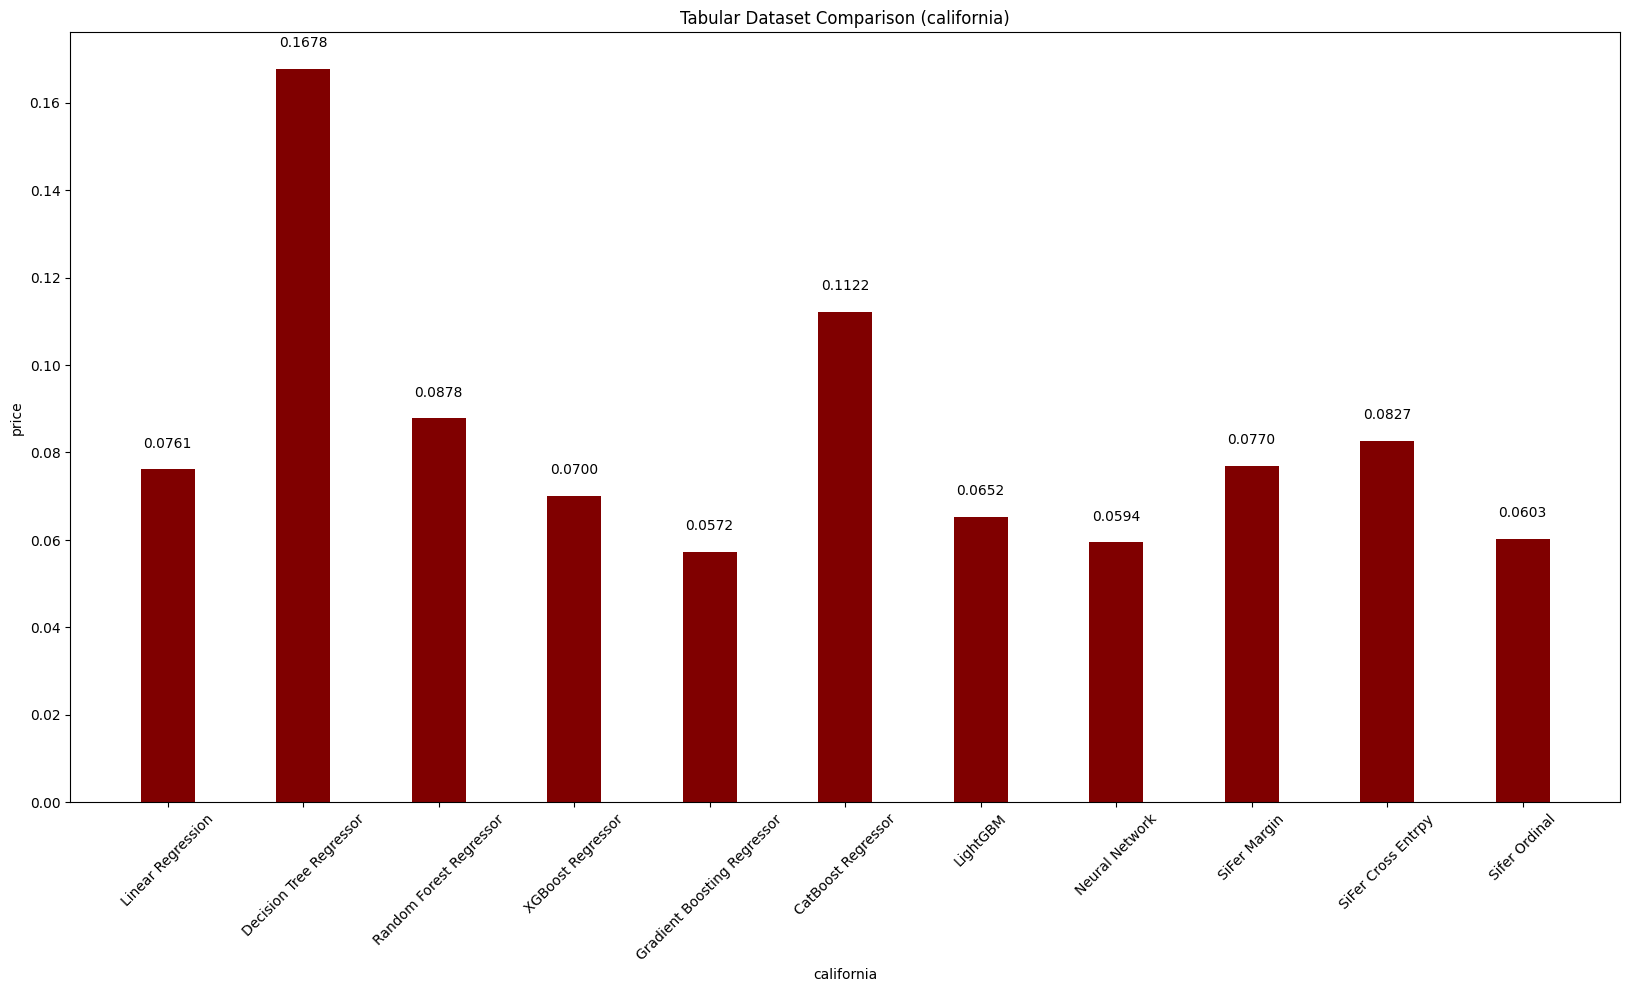

In [32]:
dict_ = {
    "Linear Regression":test_loss_lr,
    "Decision Tree Regressor":test_loss_dtr,
    "Random Forest Regressor": test_loss_rf,
    "XGBoost Regressor": test_loss_xgb, 
    "Gradient Boosting Regressor": test_loss_gbt, 
    "CatBoost Regressor": test_loss_cat, 
    "LightGBM": test_loss_lgbm, 
    "Neural Network": test_loss_mlp, 
    "SiFer Margin": test_loss_margin, 
    "SiFer Cross Entrpy": test_loss_cross, 
    "Sifer Ordinal": test_loss_ord
}
bar_plot(dict_, f"{dataset_name}", df['target_names'][0], f"Tabular Dataset Comparison ({dataset_name})", f'tab-data-{dataset_name}')

In [33]:
results_df = pd.DataFrame(dict_.values(), index = dict_.keys(), columns = [df['target_names'][0]])
results_df[df['target_names'][0]] = results_df[df['target_names'][0]].apply(lambda x: float(x))
results_df.to_csv(f"./Outputs/Regression/tab-data-{dataset_name}.csv")
results_df

,price
Linear Regression,0.076144
Decision Tree Regressor,0.167776
Random Forest Regressor,0.087777
XGBoost Regressor,0.070043
Gradient Boosting Regressor,0.057203
CatBoost Regressor,0.112159
LightGBM,0.065214
Neural Network,0.059421
SiFer Margin,0.077007
SiFer Cross Entrpy,0.082726
